## Multi-label classification

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
from fastai.conv_learner import *


In [10]:
from fastai.model import *

In [11]:
PATH = 'data/'

In [12]:
ls {PATH}

ARXIV_V5_CHESTXRAY.pdf  LOG_CHESTXRAY.pdf     images/        tmp/
BBox_List_2017.csv      README_CHESTXRAY.pdf  labels.csv     train-jpg@
Data_Entry_2017.csv     Untitled.ipynb        models/        train_v2.csv@
FAQ_CHESTXRAY.pdf       dogscats/             test_list.txt  train_val_list.txt


In [13]:
from fastai.plots import *

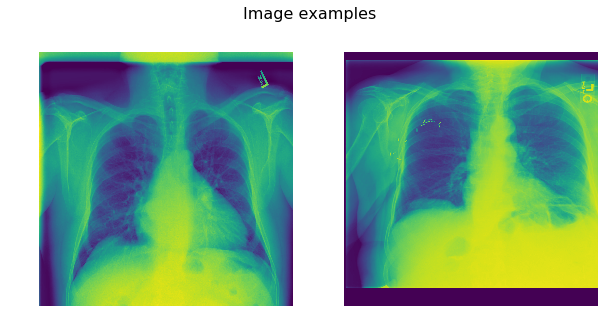

In [14]:
list_paths = [f"{PATH}images/00000001_001.jpg", f"{PATH}images/00000003_002.jpg"]

plots_from_files(list_paths, maintitle="Image examples")

In [9]:
f_model = resnext50

In [10]:
df = pd.read_csv(f'{PATH}Data_Entry_2017.csv')

In [11]:
df.head()

,Unnamed: 0,Image Index,Finding Labels
0,0,00000001_000.png,Cardiomegaly
1,1,00000001_001.png,Cardiomegaly|Emphysema
2,2,00000001_002.png,Cardiomegaly|Effusion
3,3,00000002_000.png,No Finding
4,4,00000003_000.png,Hernia


In [12]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [13]:
mask = df["Finding Labels"] != "No Finding"
column_name = "Finding Labels"
df.loc[mask, column_name] = "Pathology"

In [14]:
df.replace(' ', '_', regex=True, inplace=True)

In [15]:
df.replace('png', 'jpg', regex=True, inplace=True)

In [16]:
df.to_csv('data/labels.csv', index = False)

In [17]:
label_csv = 'data/labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [19]:
!head -10 'data/labels.csv'

Image Index,Finding Labels
00000001_000.jpg,Pathology
00000001_001.jpg,Pathology
00000001_002.jpg,Pathology
00000002_000.jpg,No_Finding
00000003_000.jpg,Pathology
00000003_001.jpg,Pathology
00000003_002.jpg,Pathology
00000003_003.jpg,Pathology
00000003_004.jpg,Pathology


In [23]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=None, max_zoom=1.10)
    return ImageClassifierData.from_csv(PATH, folder = 'images', csv_fname= 'data/labels.csv', bs = 32, tfms=tfms, val_idxs=val_idxs)

In [24]:
data = get_data(256)

In [25]:
x,y = next(iter(data.val_dl))

In [26]:
list(zip(data.classes, y))

[('No_Finding', 0), ('Pathology', 1)]

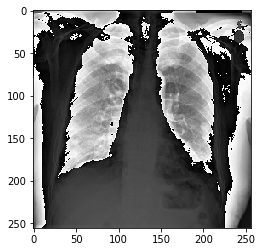

In [27]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [88]:
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [28]:
learn = ConvLearner.pretrained(f_model, data)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 77%|███████▋  | 2153/2803 [20:48<06:16,  1.72it/s, loss=2.79] 

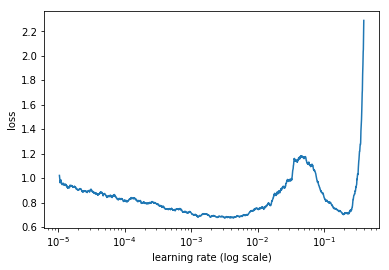

In [29]:
lrf=learn.lr_find()
learn.sched.plot()

In [31]:
lr = 10 ** -1

In [32]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  0%|          | 13/2803 [00:08<30:56,  1.50it/s, loss=0.963]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.624704   0.613363   0.67426   
    1      0.62396    0.617633   0.665983                      
    2      0.618404   0.607621   0.679372                      
    3      0.625529   0.621061   0.66206                       
    4      0.621894   0.619348   0.668509                      
    5      0.615462   0.605987   0.681408                      
    6      0.613809   0.605103   0.683027                      



[0.60510266, 0.6830272229863982]

In [38]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.unfreeze()
learn.fit(lrs, 4, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                        
    0      0.573481   0.571986   0.714069  
    1      0.583618   0.603893   0.701305                        
    2      0.562864   0.56492    0.718379                        
    3      0.578888   0.575971   0.708957                        
    4      0.563471   0.565707   0.719389                        
    5      0.53989    0.564439   0.717977                        
    6      0.524576   0.582572   0.71239                         
    7      0.596609   0.584786   0.708883                        
    8      0.573509   0.584656   0.698942                        
    9      0.559573   0.579681   0.700369                        
    10     0.539274   0.569615   0.715258                        
 82%|████████▏ | 2301/2803 [51:32<11:14,  1.34s/it, loss=0.517] 

In [ ]:
learn.save(f'{sz}')